In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import altair as alt
from scipy import stats
plt.style.use('ggplot')

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

seed = 42

In [3]:
products_file = '../data/olist_products_dataset.parquet'
orders_file = '../data/olist_orders_dataset.parquet'
order_items_file = '../data/olist_order_items_dataset.parquet'
customers_file = '../data/olist_customers_dataset.parquet'
geolocation_file = '../data/olist_geolocation_dataset.parquet'
payments_file = '../data/olist_order_payments_dataset.parquet'
reviews_file = '../data/olist_order_reviews_dataset.parquet'
sellers_file = '../data/olist_sellers_dataset.parquet'
category_file = '../data/product_category_name_translation.parquet'

In [4]:
products_df = load_data(products_file)
orders_df = load_data(orders_file)
order_items_df = load_data(order_items_file)
customers_df = load_data(customers_file)
geolocation_df = load_data(geolocation_file)
payments_df = load_data(payments_file)
reviews_df = load_data(reviews_file)
sellers_df = load_data(sellers_file)
category_df = load_data(category_file)

In [5]:
# Merge dos dataframes
orders_products = orders_df.merge(order_items_df, on='order_id', how='inner')
orders_products_customers = orders_products.merge(customers_df, on='customer_id', how='inner')
orders_products_customers_reviews = orders_products_customers.merge(reviews_df, on='order_id', how='inner')
orders_products_customers_reviews_payments = orders_products_customers_reviews.merge(payments_df, on='order_id', how='inner')
orders_products_customers_reviews_payments_sellers = orders_products_customers_reviews_payments.merge(sellers_df, on='seller_id', how='inner')
df = orders_products_customers_reviews_payments_sellers.merge(products_df, on='product_id', how='inner')
df = df.merge(category_df, on='product_category_name', how='inner')

In [6]:
def resumirtabela(df):
    print(f"Shape: {df.shape}")
    resumo = pd.DataFrame(df.dtypes, columns=['dtypes'])
    resumo = resumo.reset_index()
    resumo['Name'] = resumo['index']
    resumo = resumo[['Name', 'dtypes']]
    resumo['Missing'] = df.isnull().sum().values
    resumo['Uniques'] = df.nunique().values
    resumo['First Value'] = df.loc[0].values
    resumo['Second Value'] = df.loc[1].values
    resumo['Third Value'] = df.loc[2].values

    for name in resumo['Name'].value_counts().index:
        resumo.loc[resumo['Name'] == name, 'Entropy'] = round(
            stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    return resumo

In [7]:
resumirtabela(df)

Shape: (115609, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,96516,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,16.41
1,customer_id,object,0,96516,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,16.41
2,order_status,object,0,7,delivered,delivered,delivered,0.18
3,order_purchase_timestamp,object,0,95989,2017-10-02 10:56:33,2017-10-02 10:56:33,2017-10-02 10:56:33,16.40
4,order_approved_at,object,14,88332,2017-10-02 11:07:15,2017-10-02 11:07:15,2017-10-02 11:07:15,16.24
5,order_delivered_carrier_date,object,1195,79241,2017-10-04 19:55:00,2017-10-04 19:55:00,2017-10-04 19:55:00,16.00
6,order_delivered_customer_date,object,2400,93702,2017-10-10 21:25:13,2017-10-10 21:25:13,2017-10-10 21:25:13,16.37
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,2017-10-18 00:00:00,2017-10-18 00:00:00,8.47
8,order_item_id,int64,0,21,1,1,1,0.72
9,product_id,object,0,32171,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,13.60


In [8]:
id_cols = [
    'order_id', 'seller_id', 'customer_id', 'order_item_id',
      'product_id', 'review_id', 'customer_unique_id', 'seller_zip_code_prefix']

cat_cols = df.nunique()[df.nunique() <= 27].keys().tolist()

num_cols = num_cols = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_lenght',
                   'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']

bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()

multi_cols = [i for i in cat_cols if i not in bin_cols]

timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']

In [9]:
corr = df[num_cols].corr()

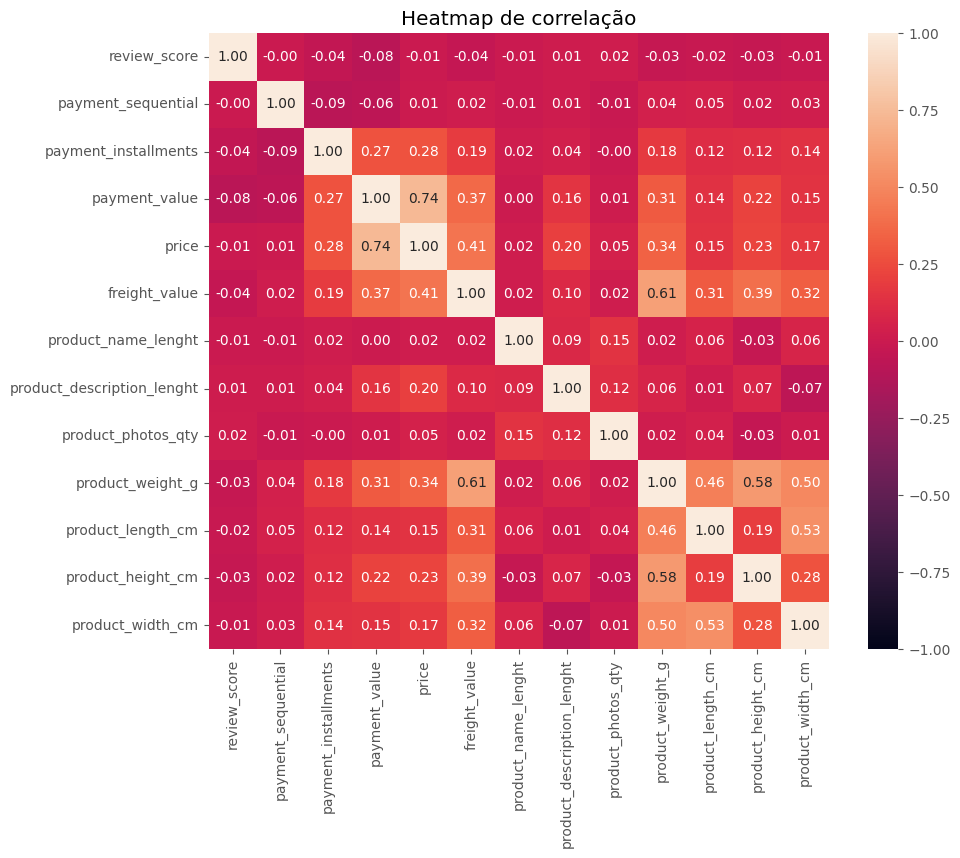

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr,  norm=plt.Normalize(-1, 1), annot=True, fmt='.2f')
plt.title("Heatmap de correlação")
plt.show()

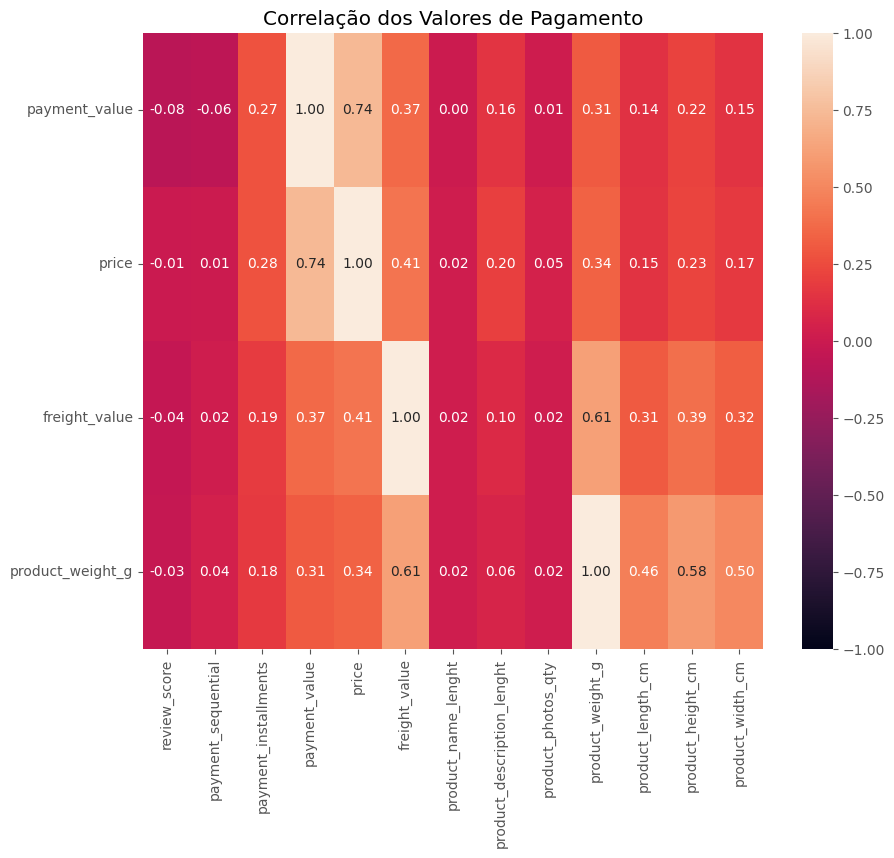

In [11]:
plt.figure(figsize=(10,8))
plt.title("Correlação dos Valores de Pagamento")
corr_payment_value = corr.loc[(corr['payment_value'] > 0.3) | (corr['payment_value'] <= -0.3)]
g1 = sns.heatmap(corr_payment_value, norm=plt.Normalize(-1, 1), annot=True, fmt='.2f')
g1.set_yticklabels(g1.get_yticklabels(),rotation=0)
plt.show()

In [12]:
df_sample = df.sample(500, random_state=seed)

In [13]:
df_sample['product_weight_g'] = df_sample['product_weight_g'].apply(lambda x: x/1000)
df_sample = df_sample.rename(columns={'product_weight_g': 'product_weight_kg'})

In [14]:
payment_value_q99 = df_sample['payment_value'].quantile(0.99)
df_sample = df_sample[df_sample['payment_value'] < payment_value_q99]

In [15]:
freight_value_q99 = df_sample['freight_value'].quantile(0.99)
df_sample = df_sample[df_sample['freight_value'] < freight_value_q99]

In [16]:
product_weight_q95 = df_sample['product_weight_kg'].quantile(0.95)
df_sample = df_sample[df_sample['product_weight_kg'] < product_weight_q95]

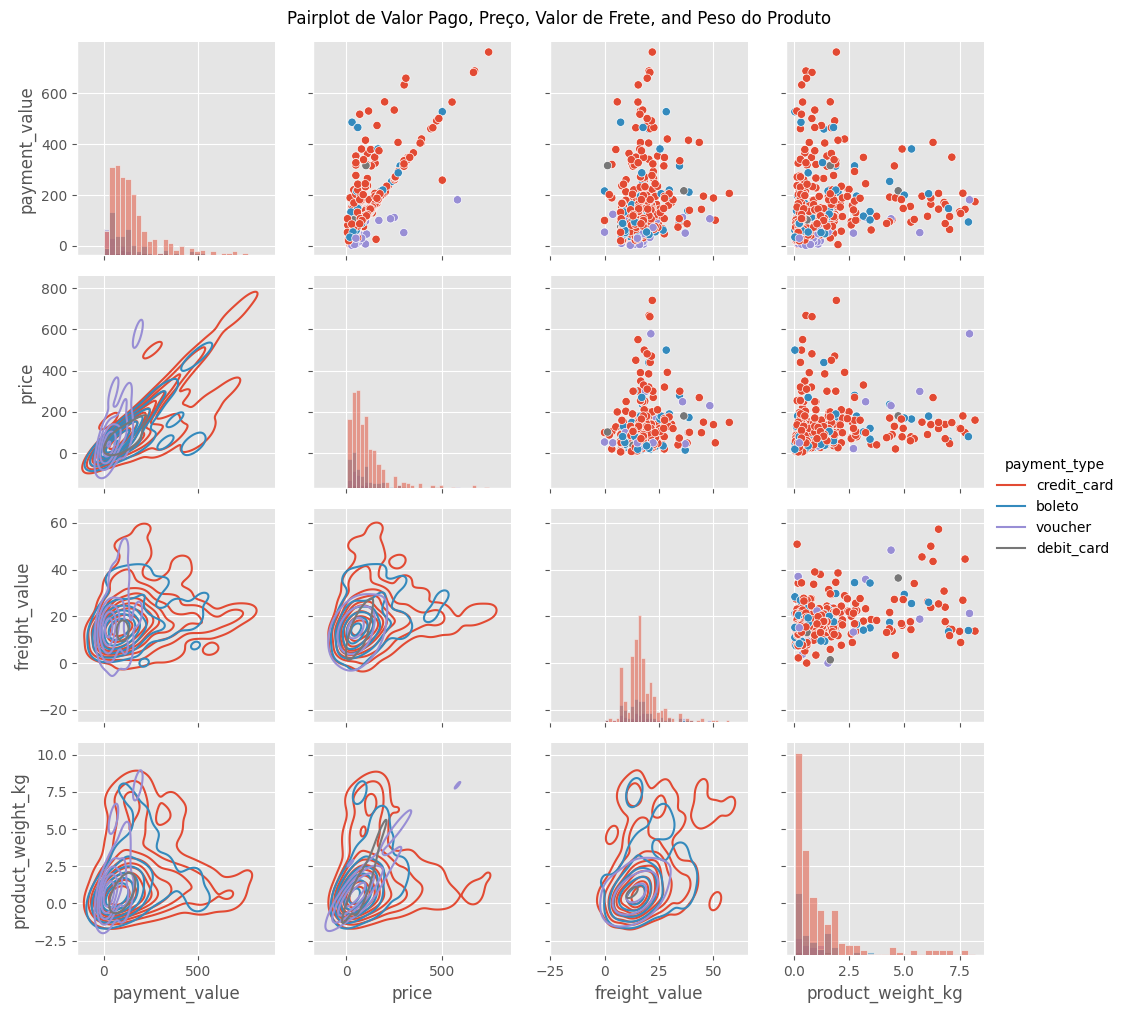

In [17]:
g = sns.PairGrid(df_sample, hue='payment_type',
                 vars=['payment_value', 'price', 'freight_value', 'product_weight_kg'])
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot)
g.add_legend()
g.figure.suptitle('Pairplot de Valor Pago, Preço, Valor de Frete, and Peso do Produto', y=1.01)
plt.show()

## Distribuição dos preços

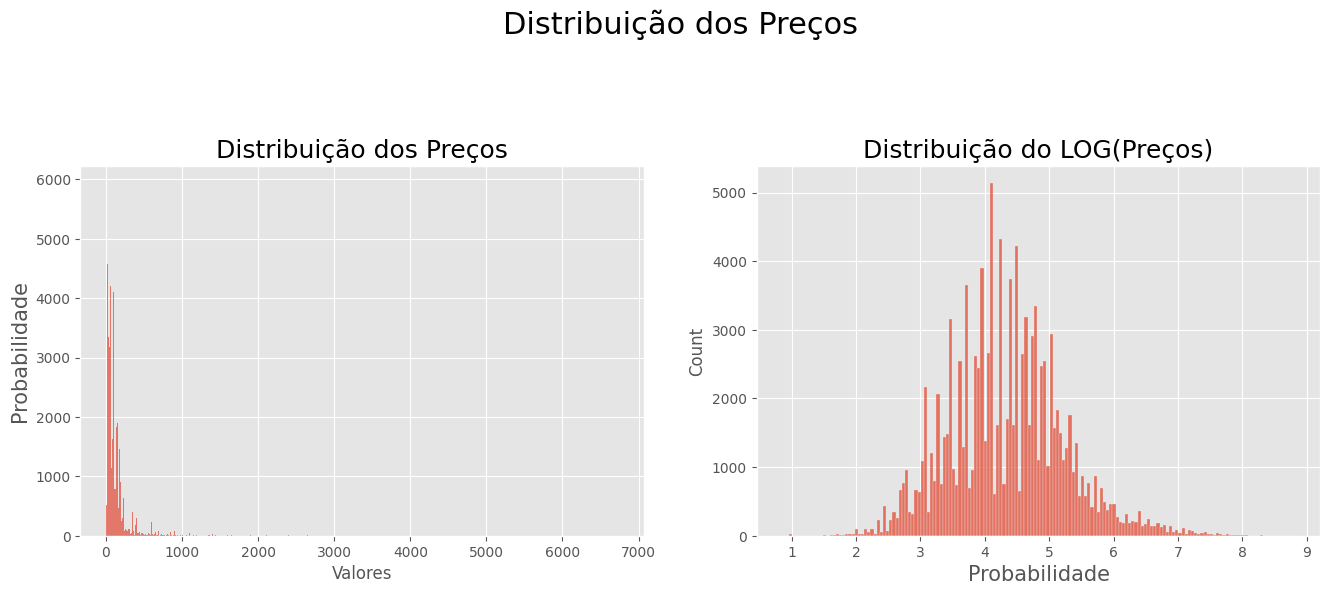

In [34]:
df.fillna({'price': -1}, inplace=True)

plt.figure(figsize=(16, 12))
plt.suptitle('Distribuição dos Preços', fontsize=22)
plt.subplot(221)
g = sns.histplot(df['price'])
g.set_title('Distribuição dos Preços', fontsize=18)
g.set_xlabel('Valores')
g.set_ylabel('Probabilidade', fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df['price']+1.5))
g1.set_title("Distribuição do LOG(Preços)", fontsize=18)
g1.set_xlabel("Valores")
g1.set_xlabel("Probabilidade", fontsize=15)

plt.subplots_adjust(hspace=0.4, top=0.85)

plt.show()

In [19]:
media_precos = df['price'].mean()
desvio_padrao_precos = df['price'].std()
print(f"Média dos preços é: {media_precos}\nDesvio Padrão é: {desvio_padrao_precos}")

Média dos preços é: 120.61984957918503
Desvio Padrão é: 182.6534760260345


# Tipos de Pagamento

In [20]:
df['price_log'] = np.log(df['price'] + 1.5)

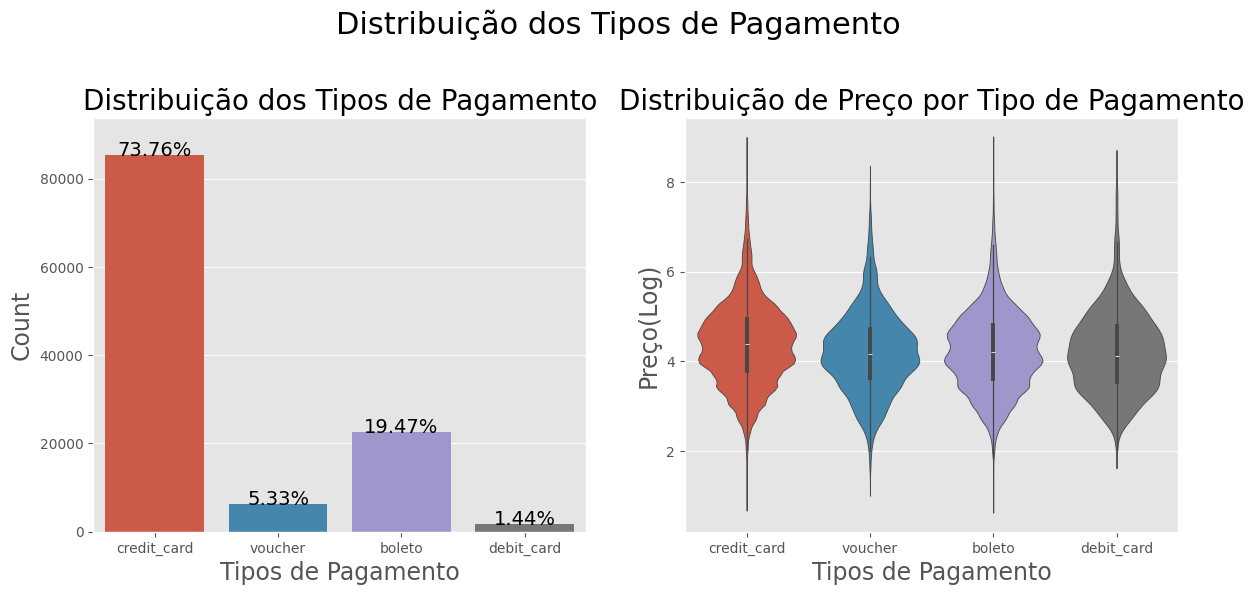

In [21]:
total = len(df)

plt.figure(figsize=(14,6))

plt.suptitle('Distribuição dos Tipos de Pagamento', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=df[df['payment_type'] != 'not_defined'], hue='payment_type')
g.set_title("Distribuição dos Tipos de Pagamento", fontsize=20)
g.set_xlabel("Tipos de Pagamento", fontsize=17)
g.set_ylabel("Count", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.violinplot(x='payment_type', y='price_log', data=df[df['payment_type'] != 'not_defined'], hue='payment_type')
g.set_title("Distribuição de Preço por Tipo de Pagamento", fontsize=20)
g.set_xlabel("Tipos de Pagamento", fontsize=17)
g.set_ylabel("Preço(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\2390289422.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g_ticks,rotation=45)
C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\2390289422.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g2.set_xticklabels(g2_ticks,rotation=45)
C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\2390289422.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g3.set_xticklabels(g3_ticks,rotation=45)


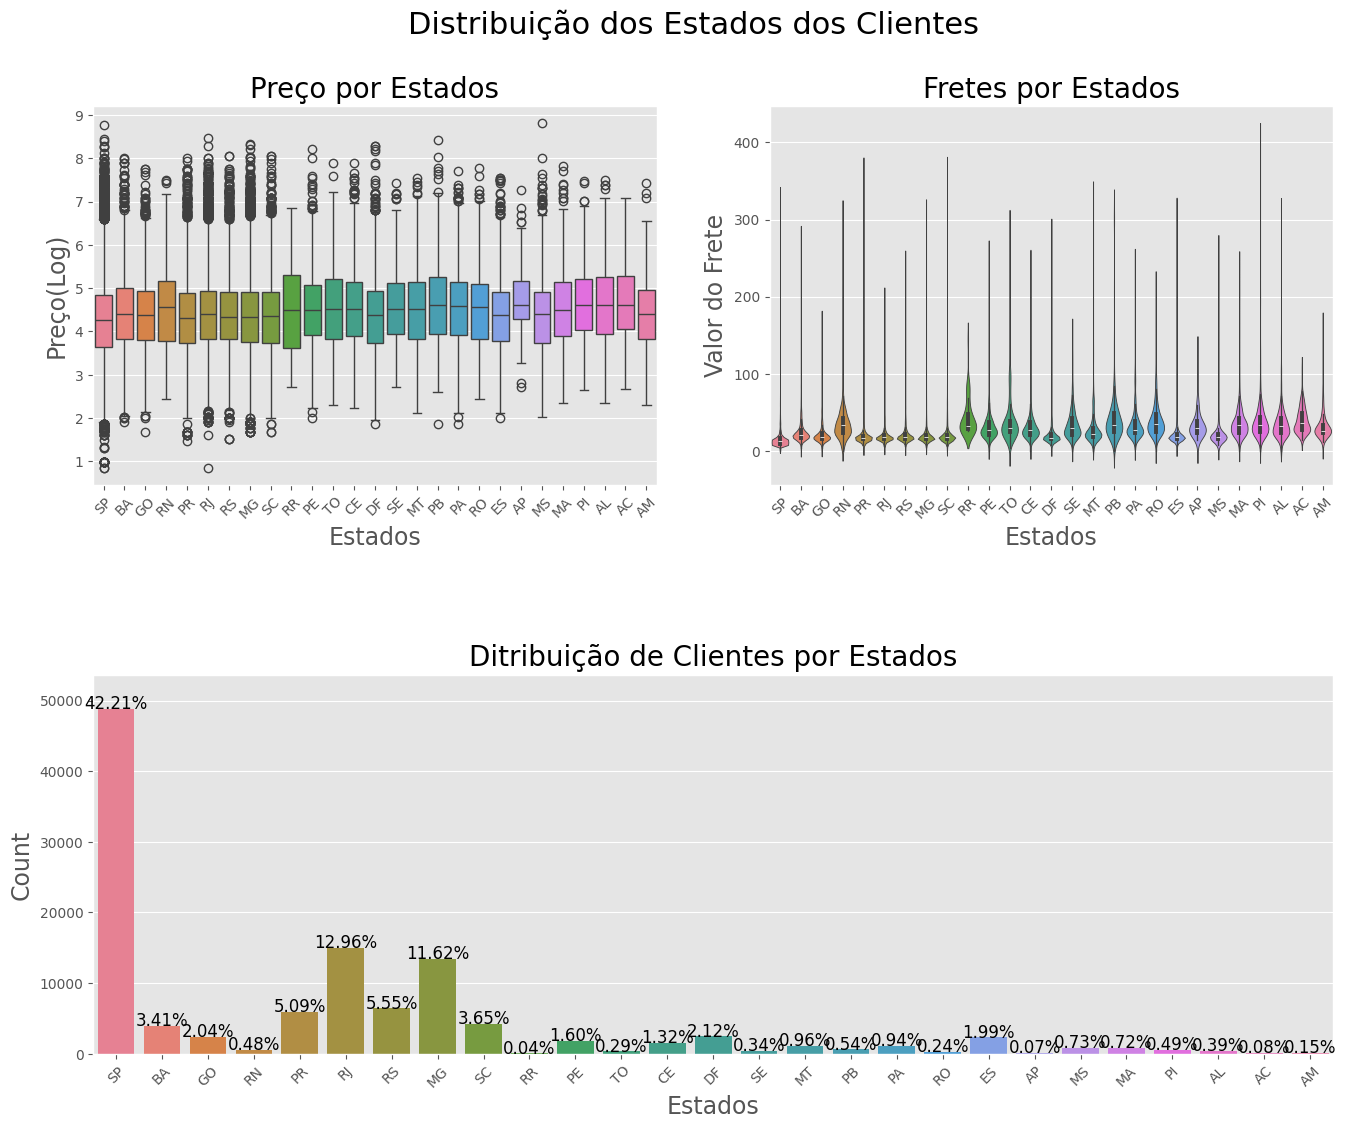

In [22]:
plt.figure(figsize=(16,12))

plt.suptitle('Distribuição dos Estados dos Clientes', fontsize=22)

plt.subplot(212)
g = sns.countplot(x='customer_state', data=df, orient='h', hue='customer_state')
g.set_title("Ditribuição de Clientes por Estados", fontsize=20)
g.set_xlabel("Estados", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g_ticks = g.get_xticklabels()
g.set_xticklabels(g_ticks,rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(221)
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df[df['price'] != -1], hue='customer_state')
g2.set_title("Preço por Estados", fontsize=20)
g2.set_xlabel("Estados", fontsize=17)
g2.set_ylabel("Preço(Log)", fontsize=17)
g2_ticks = g2.get_xticklabels()
g2.set_xticklabels(g2_ticks,rotation=45)

plt.subplot(222)
g3 = sns.violinplot(x='customer_state', y='freight_value', 
                 data=df[df['price'] != -1], hue='customer_state')
g3.set_title("Fretes por Estados", fontsize=20)
g3.set_xlabel("Estados", fontsize=17)
g3.set_ylabel("Valor do Frete", fontsize=17)
g3_ticks = g3.get_xticklabels()
g3.set_xticklabels(g3_ticks,rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\3651909600.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g_ticks,rotation=45)
C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\3651909600.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g2.set_xticklabels(g2_ticks,rotation=45)
C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\3651909600.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g3.set_xticklabels(g3_ticks, rotation=45)


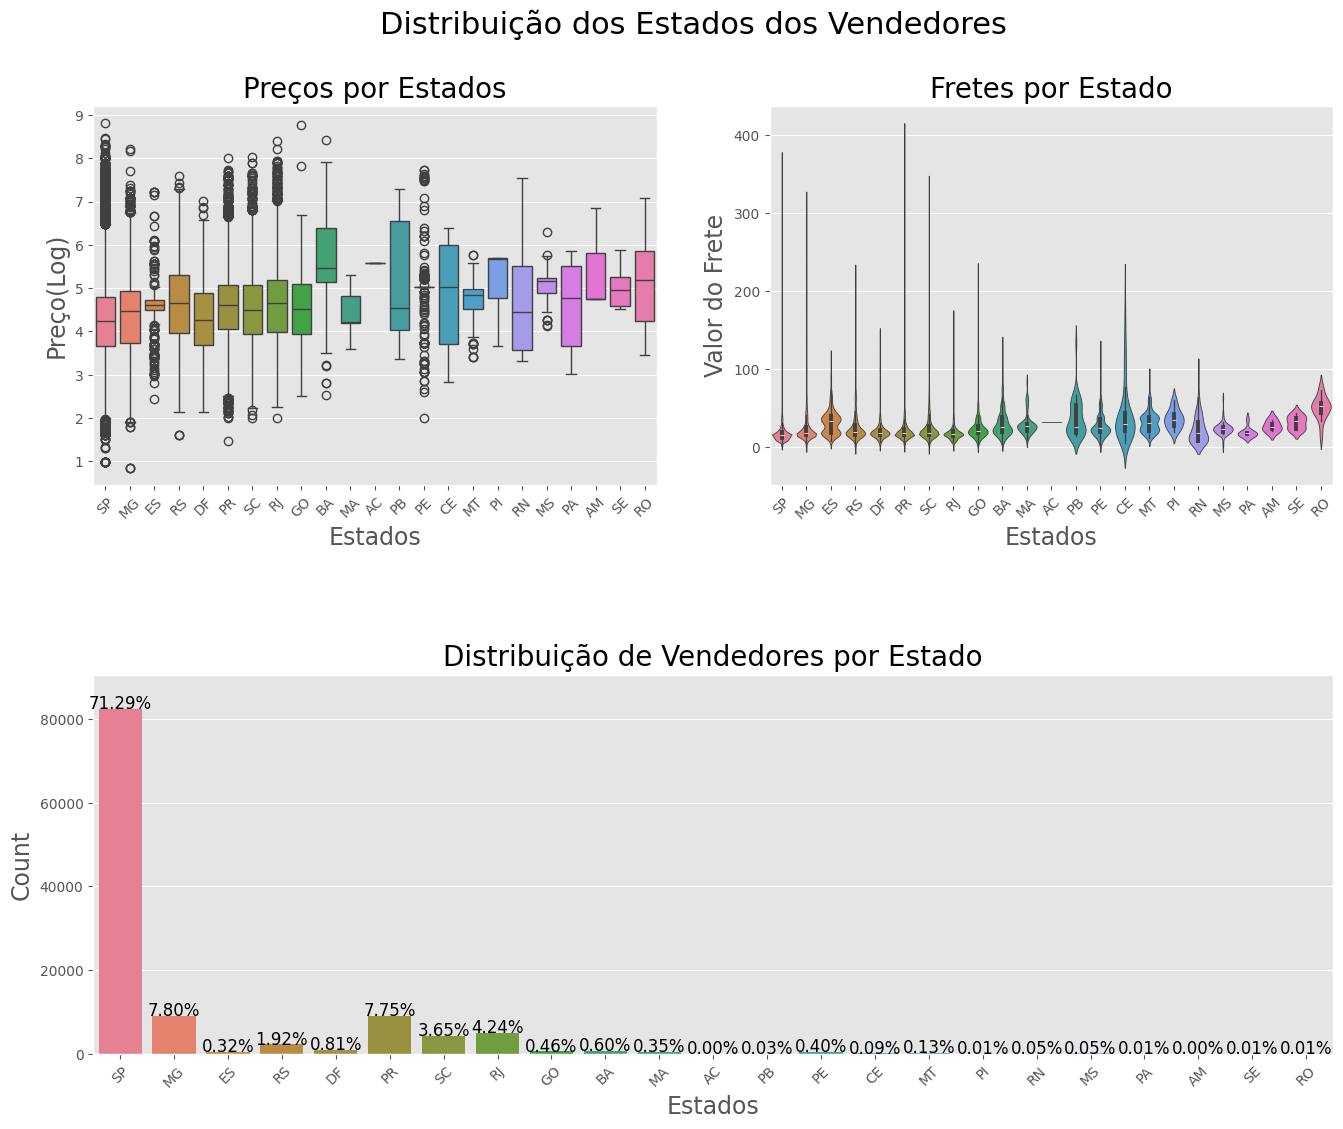

In [23]:
plt.figure(figsize=(16,12))

plt.suptitle('Distribuição dos Estados dos Vendedores', fontsize=22)

plt.subplot(212)
g = sns.countplot(x='seller_state', data=df, orient='h', hue='seller_state')
g.set_title("Distribuição de Vendedores por Estado", fontsize=20)
g.set_xlabel("Estados", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g_ticks = g.get_xticklabels()
g.set_xticklabels(g_ticks,rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(221)
g2 = sns.boxplot(x='seller_state', y='price_log', 
                 data=df[df['price'] != -1], hue='seller_state')
g2.set_title("Preços por Estados", fontsize=20)
g2.set_xlabel("Estados", fontsize=17)
g2.set_ylabel("Preço(Log)", fontsize=17)
g2_ticks = g2.get_xticklabels()
g2.set_xticklabels(g2_ticks,rotation=45)

plt.subplot(222)
g3 = sns.violinplot(x='seller_state', y='freight_value', 
                 data=df[df['price'] != -1], hue='seller_state')
g3.set_title("Fretes por Estado", fontsize=20)
g3.set_xlabel("Estados", fontsize=17)
g3.set_ylabel("Valor do Frete", fontsize=17)
g3_ticks = g3.get_xticklabels()
g3.set_xticklabels(g3_ticks, rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

In [24]:
for col in timestamp_cols:
    df[col] = pd.to_datetime(df[col])

In [25]:
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year)
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month)
df['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
df['order_purchase_time_day'] = pd.cut(df['order_purchase_hour'], hours_bins, labels=hours_labels)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Manhã
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Manhã
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Manhã
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,...,2018,7,Jul,201807,20180724,24,1,Tue,20,Noite
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,...,2018,8,Aug,201808,20180808,8,2,Wed,8,Manhã


C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\2033189723.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(weekday_label)
C:\Users\Otavio Leite\AppData\Local\Temp\ipykernel_13800\2033189723.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


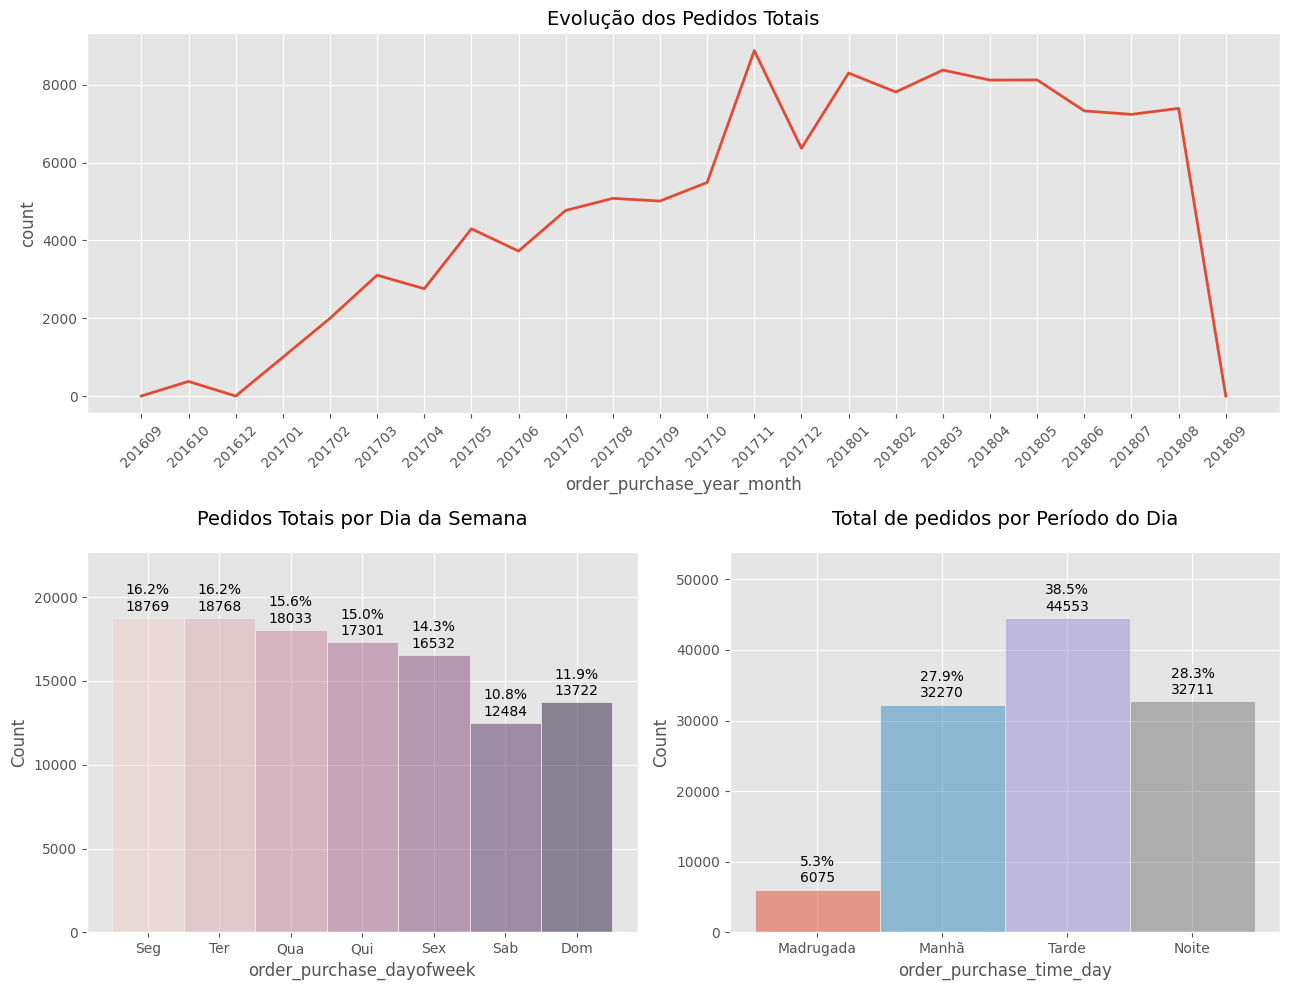

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

sns.lineplot(data=df['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, linewidth=2)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolução dos Pedidos Totais', size=14)

sns.histplot(df, x='order_purchase_dayofweek', ax=ax2, hue='order_purchase_dayofweek', legend=False,discrete=True)
weekday_label = ['Days', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Pedidos Totais por Dia da Semana', size=14, pad=20)
ax2.set_ylim(0, ax2.get_ylim()[1] * 1.15)

total = len(df['order_purchase_dayofweek'])
for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        # Adiciona número absoluto
        ax2.annotate(f'{height:.0f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points')
        # Adiciona porcentagem
        ax2.annotate(f'{height/total:.1%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 20), 
                    textcoords='offset points')

day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
sns.histplot(df, x='order_purchase_time_day', ax=ax3, hue='order_purchase_time_day', legend=False)
ax3.set_title('Total de pedidos por Período do Dia', size=14, pad=20)
ax3.set_ylim(0, ax3.get_ylim()[1] * 1.15)

total = len(df['order_purchase_time_day'])
for p in ax3.patches:
    height = p.get_height()
    if height > 0:
        # Adiciona número absoluto
        ax3.annotate(f'{height:.0f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points')
        # Adiciona porcentagem
        ax3.annotate(f'{height/total:.1%}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', 
                    xytext=(0, 20), 
                    textcoords='offset points')

plt.tight_layout()
plt.show()